In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
catalog = 'HPIC/full_HPIC.txt'

In [10]:
df = pd.read_csv(catalog)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 6, saw 3


In [11]:
df.columns

Index(['star_name|ra|dec|ra_J2016|dec_J2016|tic_id|gaia_dr2_id|gaia_dr3_id|hip_name|tm_name|tyc_name|wds_designation|simbad_name|source_list_fl|sy_pmra|sy_pmraerr|sy_pmdec|sy_pmdecerr|sy_pmsrc|sy_pm_reflink|sy_ujmag|sy_ujmagerr|sy_ujmagsrc|sy_ujmag_reflink|sy_bmag|sy_bmagerr|sy_bmagsrc|sy_bmag_reflink|sy_vmag|sy_vmagerr|sy_vmagsrc|sy_vmag_reflink|sy_rcmag|sy_rcmagerr|sy_rcmagsrc|sy_rcmag_reflink|sy_icmag|sy_icmagerr|sy_icmagsrc|sy_icmag_reflink|sy_jmag|sy_jmagerr|sy_jmagsrc|sy_jmag_reflink|sy_hmag|sy_hmagerr|sy_hmagsrc|sy_hmag_reflink|sy_kmag|sy_kmagmerr|sy_kmagsrc|sy_kmag_reflink|sy_tmag|sy_tmagerr|sy_gaiamag|sy_gaiamagerr|sy_gaiamagsrc|sy_gaiamag_reflink|sy_bpmag|sy_bpmagerr|sy_rpmag|sy_rpmagerr|sy_plx|sy_plxerr|sy_plxsrc|sy_plx_reflink|sy_dist|sy_disterr|sy_distsrc|sy_dist_reflink|ambiguous_dist_fl|st_spectype|st_spectype_reflink|dwarf_fl|st_teff|st_tefferr|st_teffsrc|st_teff_reflink|st_logg|st_loggerr|st_loggsrc|st_logg_reflink|st_loggspec|st_loggspecerr|st_loggspecsrc|st_loggspec_

Number of simulated planets: 430
Number of detectable planets (Tier A): 311
Number of detectable planets (Tier B): 318
Number of detectable planets (Tier C): 320


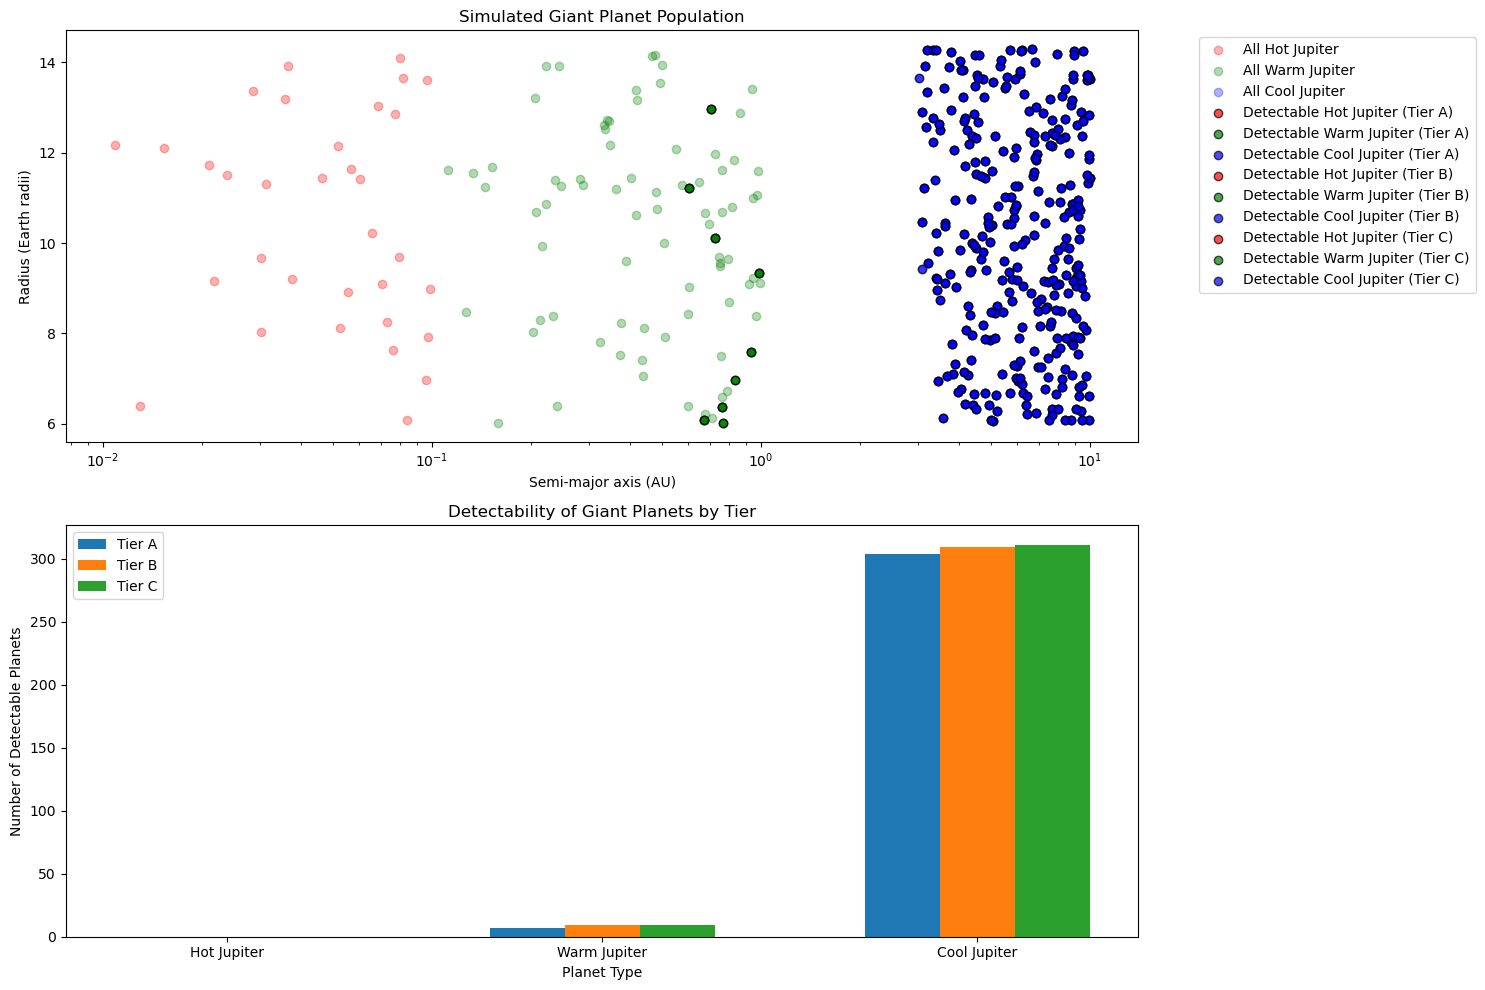

In [2]:
NUM_STARS = 1000
MIN_RADIUS = 6.0  # Earth radii
MAX_RADIUS = 14.3  # Earth radii

PLANET_TYPES = {
    'Hot Jupiter': {'min_sma': 0.01, 'max_sma': 0.1, 'eta': 0.03},
    'Warm Jupiter': {'min_sma': 0.1, 'max_sma': 1, 'eta': 0.1},
    'Cool Jupiter': {'min_sma': 3, 'max_sma': 10, 'eta': 0.32}
}

# Telescope parameters
TIERS = {
    'A': {'IWA': 0.083, 'contrast': 4e-11, 'mag_limit': 30.5},
    'B': {'IWA': 0.072, 'contrast': 4e-11, 'mag_limit': 31.0},
    'C': {'IWA': 0.065, 'contrast': 2.5e-11, 'mag_limit': 31.0}
}

star_distances = np.random.uniform(5, 50, NUM_STARS)  # parsecs
star_masses = np.random.uniform(0.5, 1.5, NUM_STARS)  # solar masses
star_magnitudes = np.random.uniform(4, 8, NUM_STARS)  # Approximate V magnitudes for nearby stars

def simulate_planets(star_masses, star_distances):
    planets = []
    for i in range(NUM_STARS):
        for ptype, params in PLANET_TYPES.items():
            if np.random.random() < params['eta']:
                semi_major_axis = np.random.uniform(params['min_sma'], params['max_sma'])
                radius = np.random.uniform(MIN_RADIUS, MAX_RADIUS)
                planets.append({
                    'star_index': i,
                    'semi_major_axis': semi_major_axis,
                    'radius': radius,
                    'distance': star_distances[i],
                    'star_magnitude': star_magnitudes[i],
                    'type': ptype
                })
    return planets

def is_detectable(planet, tier):
    apparent_separation = planet['semi_major_axis'] / planet['distance']
    
    alpha = np.radians(63.3)
    
    # Phase function for a Lambertian sphere
    phi = (np.sin(alpha) + (np.pi - alpha) * np.cos(alpha)) / np.pi
    
    albedo = 0.2  
    contrast = albedo * phi * (planet['radius'] / (planet['semi_major_axis'] * 215))**2

    planet_mag = planet['star_magnitude'] - 2.5 * np.log10(contrast)
    
    return (apparent_separation > TIERS[tier]['IWA'] and 
            contrast > TIERS[tier]['contrast'] and 
            planet_mag <= TIERS[tier]['mag_limit'])

planets = simulate_planets(star_masses, star_distances)

detectable = {tier: [p for p in planets if is_detectable(p, tier)] for tier in TIERS}

print(f"Number of simulated planets: {len(planets)}")
for tier in TIERS:
    print(f"Number of detectable planets (Tier {tier}): {len(detectable[tier])}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
colors = {'Hot Jupiter': 'red', 'Warm Jupiter': 'green', 'Cool Jupiter': 'blue'}
for ptype in PLANET_TYPES:
    p_all = [p for p in planets if p['type'] == ptype]
    plt.scatter([p['semi_major_axis'] for p in p_all], [p['radius'] for p in p_all], 
                alpha=0.3, color=colors[ptype], label=f'All {ptype}')

for tier in TIERS:
    for ptype in PLANET_TYPES:
        p_det = [p for p in detectable[tier] if p['type'] == ptype]
        plt.scatter([p['semi_major_axis'] for p in p_det], [p['radius'] for p in p_det], 
                    alpha=0.7, color=colors[ptype], edgecolors='black', 
                    label=f'Detectable {ptype} (Tier {tier})')

plt.xscale('log')
plt.xlabel('Semi-major axis (AU)')
plt.ylabel('Radius (Earth radii)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Simulated Giant Planet Population')

plt.subplot(2, 1, 2)
x = np.arange(len(PLANET_TYPES))
width = 0.2

for i, tier in enumerate(TIERS):
    counts = [len([p for p in detectable[tier] if p['type'] == ptype]) for ptype in PLANET_TYPES]
    plt.bar(x + i*width, counts, width, label=f'Tier {tier}')

plt.xlabel('Planet Type')
plt.ylabel('Number of Detectable Planets')
plt.title('Detectability of Giant Planets by Tier')
plt.xticks(x + width, PLANET_TYPES.keys())
plt.legend()

plt.tight_layout()
plt.show()

Number of simulated planets: 466
Number of detectable planets (Tier A): 292
Number of detectable planets (Tier B): 284
Number of detectable planets (Tier C): 279


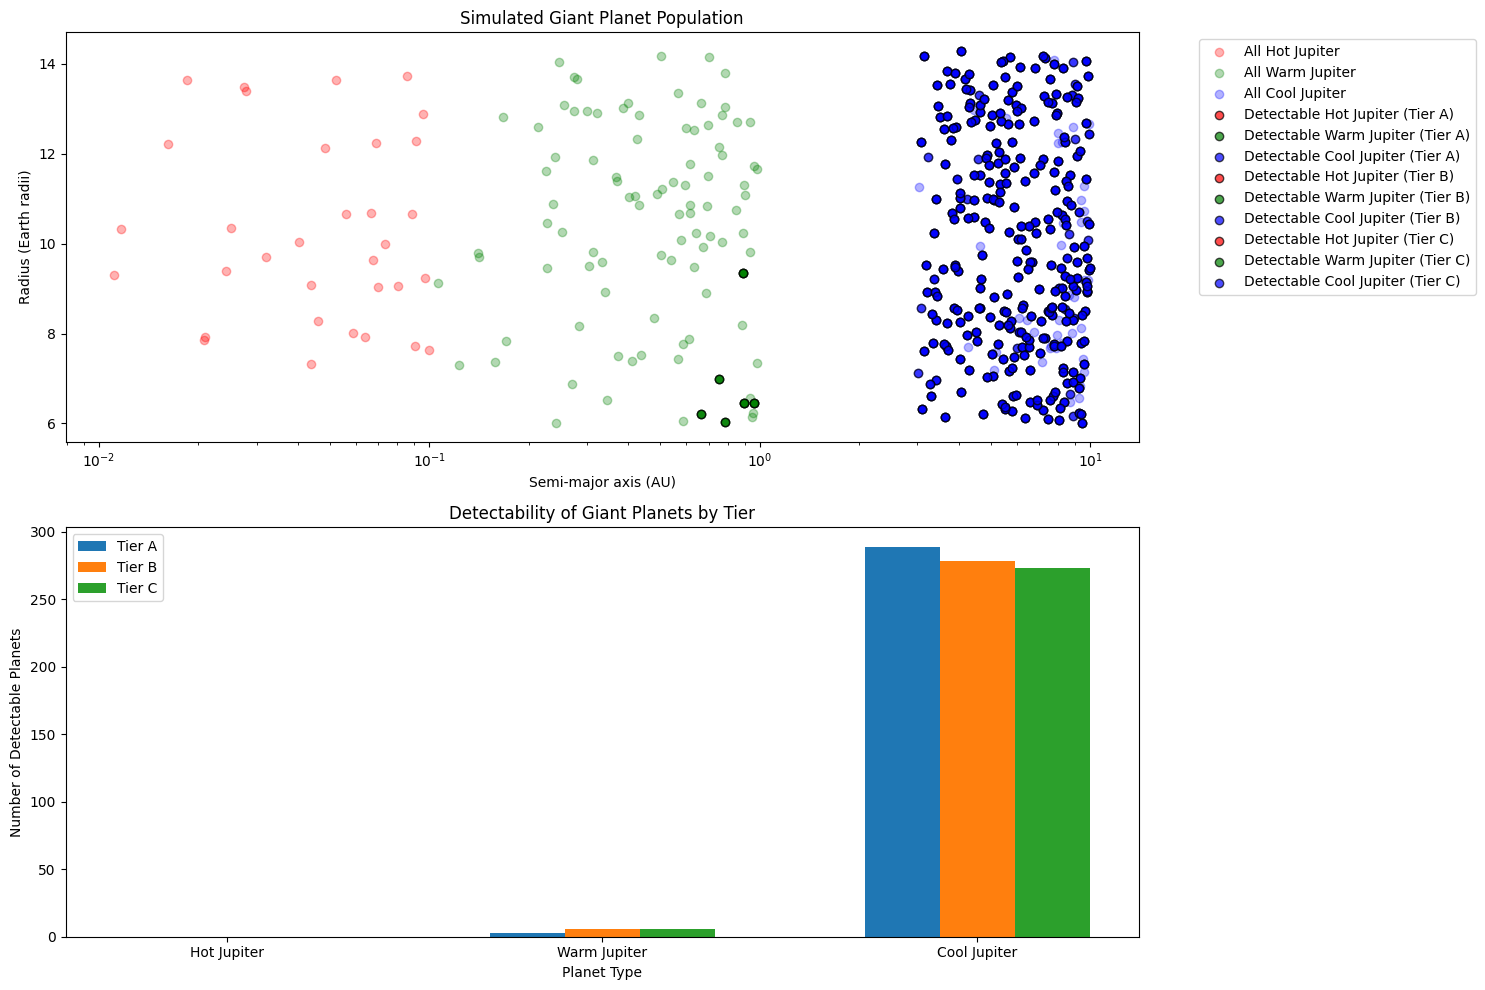

In [5]:
import numpy as np
import matplotlib.pyplot as plt

NUM_STARS = 1000
MIN_RADIUS = 6.0  # Earth radii
MAX_RADIUS = 14.3  # Earth radii

PLANET_TYPES = {
    'Hot Jupiter': {'min_sma': 0.01, 'max_sma': 0.1, 'eta': 0.03},
    'Warm Jupiter': {'min_sma': 0.1, 'max_sma': 1, 'eta': 0.1},
    'Cool Jupiter': {'min_sma': 3, 'max_sma': 10, 'eta': 0.32}
}

# Telescope parameters
TIERS = {
    'A': {'IWA': 0.083, 'OWA': 0.664, 'contrast': 4e-11, 'mag_limit': 30.5},
    'B': {'IWA': 0.072, 'OWA': 0.576, 'contrast': 4e-11, 'mag_limit': 31.0},
    'C': {'IWA': 0.065, 'OWA': 0.520, 'contrast': 2.5e-11, 'mag_limit': 31.0}
}

star_distances = np.random.uniform(5, 50, NUM_STARS)  # parsecs
star_masses = np.random.uniform(0.5, 1.5, NUM_STARS)  # solar masses
star_magnitudes = np.random.uniform(4, 8, NUM_STARS)  # Approximate V magnitudes for nearby stars

def simulate_planets(star_masses, star_distances):
    planets = []
    for i in range(NUM_STARS):
        for ptype, params in PLANET_TYPES.items():
            if np.random.random() < params['eta']:
                semi_major_axis = np.random.uniform(params['min_sma'], params['max_sma'])
                radius = np.random.uniform(MIN_RADIUS, MAX_RADIUS)
                planets.append({
                    'star_index': i,
                    'semi_major_axis': semi_major_axis,
                    'radius': radius,
                    'distance': star_distances[i],
                    'star_magnitude': star_magnitudes[i],
                    'type': ptype
                })
    return planets

def is_detectable(planet, tier):
    apparent_separation = planet['semi_major_axis'] / planet['distance']
    
    alpha = np.radians(63.3)
    
    # Phase function for a Lambertian sphere
    phi = (np.sin(alpha) + (np.pi - alpha) * np.cos(alpha)) / np.pi
    
    albedo = 0.2  
    contrast = albedo * phi * (planet['radius'] / (planet['semi_major_axis'] * 215))**2

    planet_mag = planet['star_magnitude'] - 2.5 * np.log10(contrast)
    
    return (TIERS[tier]['IWA'] < apparent_separation < TIERS[tier]['OWA'] and 
            contrast > TIERS[tier]['contrast'] and 
            planet_mag <= TIERS[tier]['mag_limit'])

planets = simulate_planets(star_masses, star_distances)

detectable = {tier: [p for p in planets if is_detectable(p, tier)] for tier in TIERS}

print(f"Number of simulated planets: {len(planets)}")
for tier in TIERS:
    print(f"Number of detectable planets (Tier {tier}): {len(detectable[tier])}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
colors = {'Hot Jupiter': 'red', 'Warm Jupiter': 'green', 'Cool Jupiter': 'blue'}
for ptype in PLANET_TYPES:
    p_all = [p for p in planets if p['type'] == ptype]
    plt.scatter([p['semi_major_axis'] for p in p_all], [p['radius'] for p in p_all], 
                alpha=0.3, color=colors[ptype], label=f'All {ptype}')

for tier in TIERS:
    for ptype in PLANET_TYPES:
        p_det = [p for p in detectable[tier] if p['type'] == ptype]
        plt.scatter([p['semi_major_axis'] for p in p_det], [p['radius'] for p in p_det], 
                    alpha=0.7, color=colors[ptype], edgecolors='black', 
                    label=f'Detectable {ptype} (Tier {tier})')

plt.xscale('log')
plt.xlabel('Semi-major axis (AU)')
plt.ylabel('Radius (Earth radii)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Simulated Giant Planet Population')

plt.subplot(2, 1, 2)
x = np.arange(len(PLANET_TYPES))
width = 0.2

for i, tier in enumerate(TIERS):
    counts = [len([p for p in detectable[tier] if p['type'] == ptype]) for ptype in PLANET_TYPES]
    plt.bar(x + i*width, counts, width, label=f'Tier {tier}')

plt.xlabel('Planet Type')
plt.ylabel('Number of Detectable Planets')
plt.title('Detectability of Giant Planets by Tier')
plt.xticks(x + width, PLANET_TYPES.keys())
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
stars = []
with open('hpiclike.txt', 'r') as file:
    headers = file.readline().strip().split('|')
    for line in file:
        data = line.strip().split('|')
        if len(data) > 100:  # Ensure we have enough data
            star = {
                'distance': float(data[66]) if data[66] != 'null' else None,
                'mass': float(data[98]) if data[98] != 'null' else None,
                'magnitude': float(data[28]) if data[28] != 'null' else None,
                'radius': float(data[94]) if data[94] != 'null' else None
            }
            if all(value is not None for value in star.values()):
                    stars.append(star)

In [22]:
headers[95]

'st_raderr'

In [14]:
data[99]

'0.040000000000000036'

Number of stars in catalog: 12499
Number of simulated planets: 5606
Number of detectable planets (Tier A): 3747
Number of detectable planets (Tier B): 3833
Number of detectable planets (Tier C): 3843


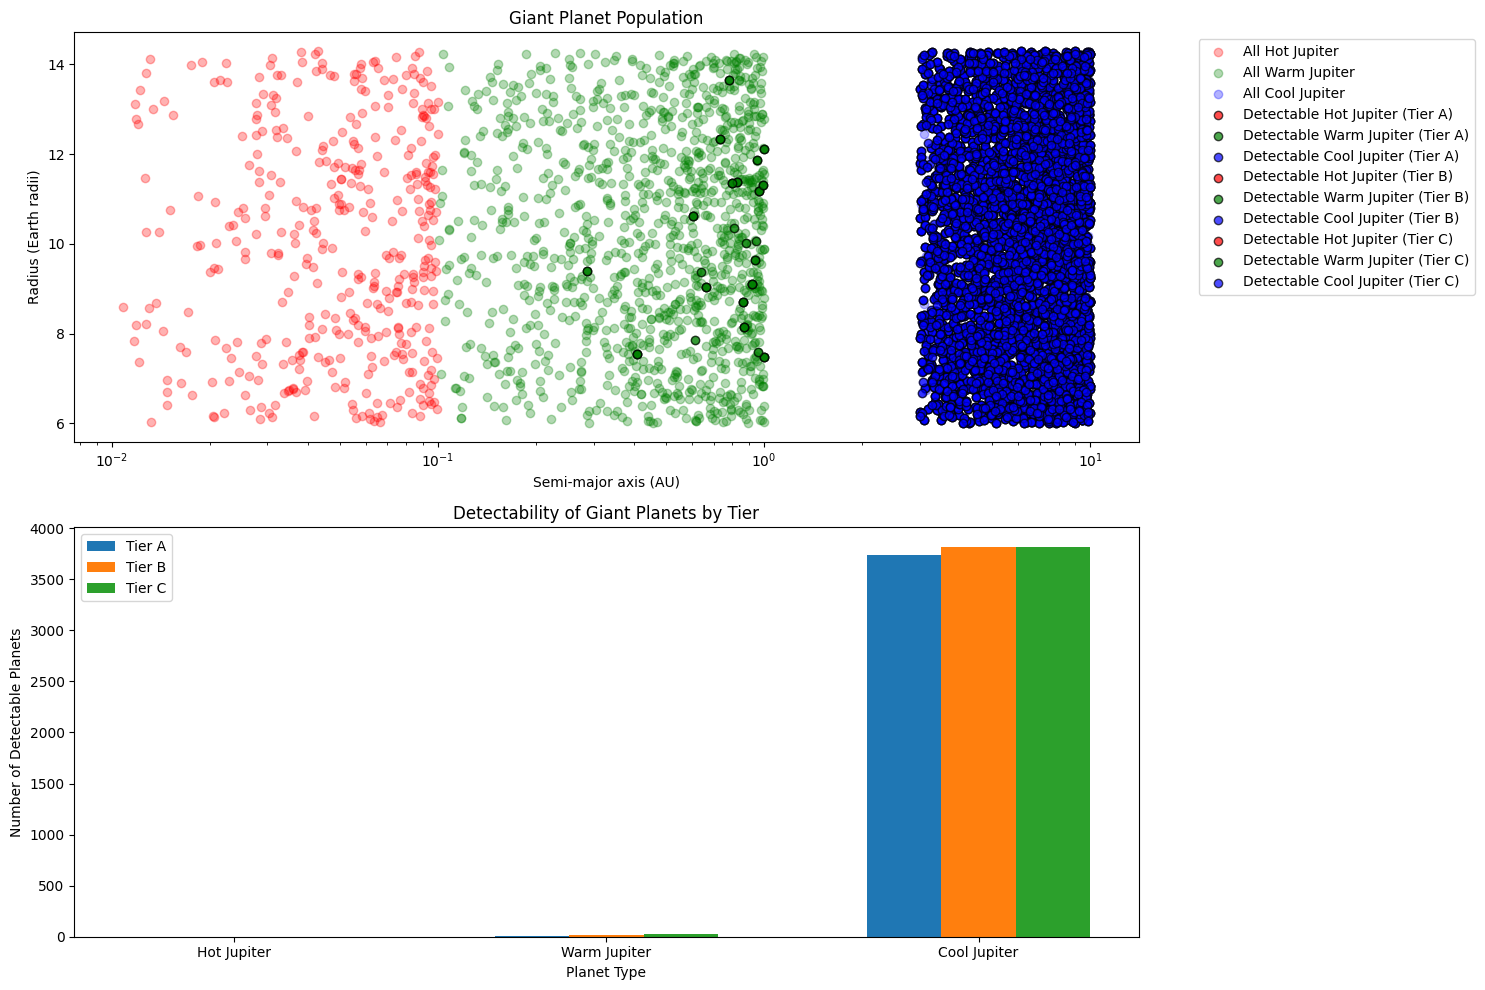

In [27]:
def parse_catalog(filename):
    stars = []
    with open(filename, 'r') as file:
        headers = file.readline().strip().split('|')
        for line in file:
            data = line.strip().split('|')
            if len(data) > 100:  # Ensure we have enough data
                star = {
                    'distance': float(data[66]) if data[66] != 'null' else None,
                    'mass': float(data[98]) if data[98] != 'null' else None,
                    'magnitude': float(data[28]) if data[28] != 'null' else None,
                    'radius': float(data[94]) if data[94] != 'null' else None
                }
                if all(value is not None for value in star.values()):
                        stars.append(star)
    return stars

# Parse the catalog
stars = parse_catalog('HPIC/full_HPIC.txt')

# Telescope parameters
TIERS = {
    'A': {'IWA': 0.083, 'OWA': 0.664, 'contrast': 4e-11, 'mag_limit': 30.5},
    'B': {'IWA': 0.072, 'OWA': 0.576, 'contrast': 4e-11, 'mag_limit': 31.0},
    'C': {'IWA': 0.065, 'OWA': 0.520, 'contrast': 2.5e-11, 'mag_limit': 31.0}
}

PLANET_TYPES = {
    'Hot Jupiter': {'min_sma': 0.01, 'max_sma': 0.1, 'eta': 0.03},
    'Warm Jupiter': {'min_sma': 0.1, 'max_sma': 1, 'eta': 0.1},
    'Cool Jupiter': {'min_sma': 3, 'max_sma': 10, 'eta': 0.32}
}

def simulate_planets(stars):
    planets = []
    for i, star in enumerate(stars):
        for ptype, params in PLANET_TYPES.items():
            if np.random.random() < params['eta']:
                semi_major_axis = np.random.uniform(params['min_sma'], params['max_sma'])
                radius = np.random.uniform(6.0, 14.3)  # Earth radii
                planets.append({
                    'star_index': i,
                    'semi_major_axis': semi_major_axis,
                    'radius': radius,
                    'distance': star['distance'],
                    'star_magnitude': star['magnitude'],
                    'type': ptype
                })
    return planets

def is_detectable(planet, tier):
    apparent_separation = planet['semi_major_axis'] / planet['distance']
    
    alpha = np.radians(63.3)
    phi = (np.sin(alpha) + (np.pi - alpha) * np.cos(alpha)) / np.pi
    
    albedo = 0.2  
    contrast = albedo * phi * (planet['radius'] / (planet['semi_major_axis'] * 215))**2

    planet_mag = planet['star_magnitude'] - 2.5 * np.log10(contrast)
    
    return (TIERS[tier]['IWA'] < apparent_separation < TIERS[tier]['OWA'] and 
            contrast > TIERS[tier]['contrast'] and 
            planet_mag <= TIERS[tier]['mag_limit'])

planets = simulate_planets(stars)

detectable = {tier: [p for p in planets if is_detectable(p, tier)] for tier in TIERS}

print(f"Number of stars in catalog: {len(stars)}")
print(f"Number of simulated planets: {len(planets)}")
for tier in TIERS:
    print(f"Number of detectable planets (Tier {tier}): {len(detectable[tier])}")

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
colors = {'Hot Jupiter': 'red', 'Warm Jupiter': 'green', 'Cool Jupiter': 'blue'}
for ptype in PLANET_TYPES:
    p_all = [p for p in planets if p['type'] == ptype]
    plt.scatter([p['semi_major_axis'] for p in p_all], [p['radius'] for p in p_all], 
                alpha=0.3, color=colors[ptype], label=f'All {ptype}')

for tier in TIERS:
    for ptype in PLANET_TYPES:
        p_det = [p for p in detectable[tier] if p['type'] == ptype]
        plt.scatter([p['semi_major_axis'] for p in p_det], [p['radius'] for p in p_det], 
                    alpha=0.7, color=colors[ptype], edgecolors='black', 
                    label=f'Detectable {ptype} (Tier {tier})')

plt.xscale('log')
plt.xlabel('Semi-major axis (AU)')
plt.ylabel('Radius (Earth radii)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Giant Planet Population')

plt.subplot(2, 1, 2)
x = np.arange(len(PLANET_TYPES))
width = 0.2

for i, tier in enumerate(TIERS):
    counts = [len([p for p in detectable[tier] if p['type'] == ptype]) for ptype in PLANET_TYPES]
    plt.bar(x + i*width, counts, width, label=f'Tier {tier}')

plt.xlabel('Planet Type')
plt.ylabel('Number of Detectable Planets')
plt.title('Detectability of Giant Planets by Tier')
plt.xticks(x + width, PLANET_TYPES.keys())
plt.legend()

plt.tight_layout()
plt.show()